In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

import statsmodels.api as sm
from sklearn.model_selection import train_test_split, KFold
from sklearn.linear_model import LinearRegression, Ridge, LassoCV
from sklearn.preprocessing import StandardScaler, PolynomialFeatures, OneHotEncoder, normalize
from sklearn.metrics import r2_score, mean_absolute_error

load data

In [2]:
df = pd.read_pickle('../data/model_spec_sales_df.pkl')
#df.drop(labels=['width_in','doors', 'length_in', 'height_in', 'volume_cuft'], axis=1, inplace=True)
df1 = df.loc[:,['price', 'doors', 'passengers', 'speed_sec', 'horsepower_hp', 'drive', 'mpg', 'engine', 'tank_gal',
                'length_in', 'width_in','height_in', 'Total_Sales']]
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4393 entries, 0 to 4392
Data columns (total 15 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Total_Sales    4310 non-null   float64
 1   Year_x         4393 non-null   object 
 2   price          3455 non-null   float64
 3   doors          4393 non-null   object 
 4   passengers     4393 non-null   object 
 5   speed_sec      3350 non-null   float64
 6   horsepower_hp  3811 non-null   float64
 7   drive          3835 non-null   object 
 8   mpg            3841 non-null   float64
 9   engine         3654 non-null   object 
 10  tank_gal       3730 non-null   float64
 11  volume_cuft    1006 non-null   float64
 12  length_in      3632 non-null   float64
 13  width_in       3740 non-null   float64
 14  height_in      3740 non-null   float64
dtypes: float64(10), object(5)
memory usage: 549.1+ KB


In [3]:
df1.dropna(inplace=True)
df1.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2761 entries, 2 to 4392
Data columns (total 13 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   price          2761 non-null   float64
 1   doors          2761 non-null   object 
 2   passengers     2761 non-null   object 
 3   speed_sec      2761 non-null   float64
 4   horsepower_hp  2761 non-null   float64
 5   drive          2761 non-null   object 
 6   mpg            2761 non-null   float64
 7   engine         2761 non-null   object 
 8   tank_gal       2761 non-null   float64
 9   length_in      2761 non-null   float64
 10  width_in       2761 non-null   float64
 11  height_in      2761 non-null   float64
 12  Total_Sales    2761 non-null   float64
dtypes: float64(9), object(4)
memory usage: 302.0+ KB


## EDA

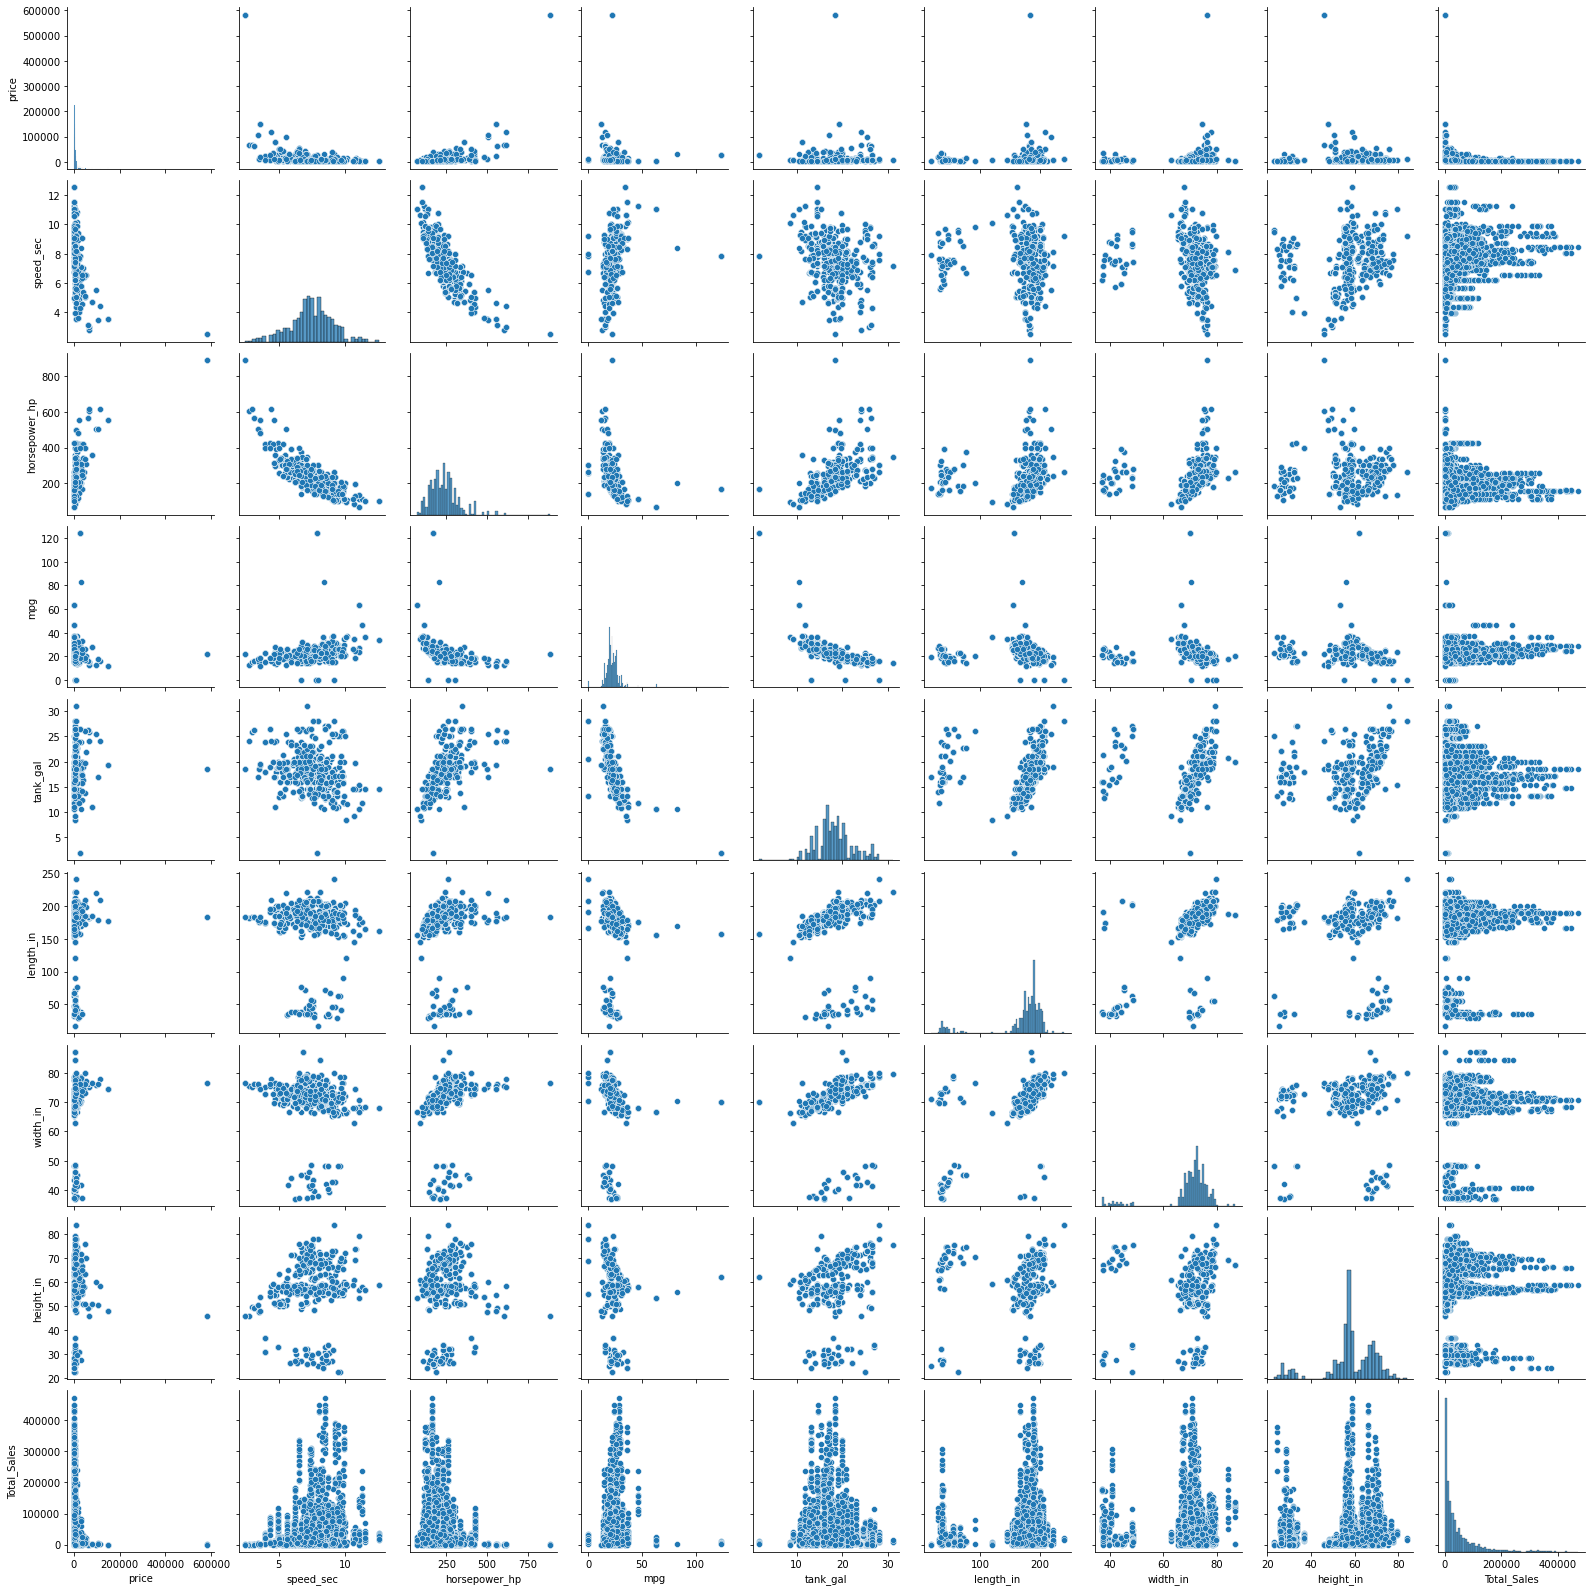

In [4]:
sns.pairplot(df1)

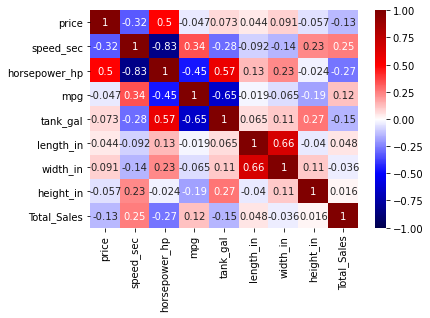

In [5]:
sns.heatmap(df1.corr(), cmap="seismic", annot=True, vmin=-1, vmax=1);

Check categorical features to see if it is related to Total Sales

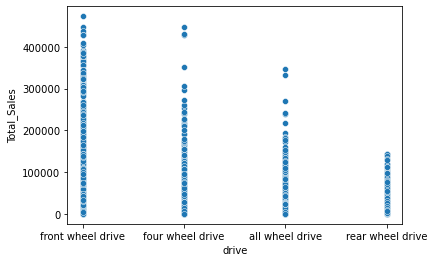

In [6]:
sns.scatterplot(x=df1['drive'], y=df1['Total_Sales'])

<AxesSubplot:xlabel='engine', ylabel='Total_Sales'>

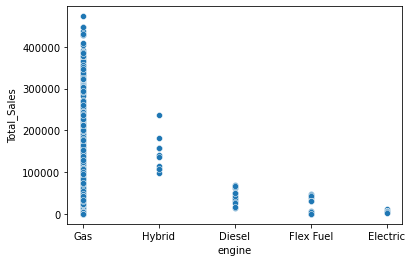

In [7]:
sns.scatterplot(x=df1['engine'], y=df1['Total_Sales'])

<AxesSubplot:xlabel='doors', ylabel='Total_Sales'>

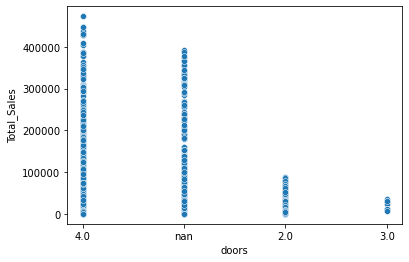

In [8]:
sns.scatterplot(x=df1['doors'], y=df1['Total_Sales'])

<AxesSubplot:xlabel='passengers', ylabel='Total_Sales'>

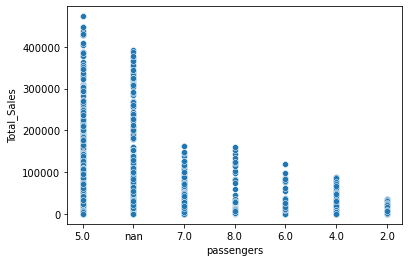

In [9]:
sns.scatterplot(x=df1['passengers'], y=df1['Total_Sales'])

#### Intial Takeaways

###### What is the distribution of the target?

##### Are there any colinearities in the feartures?

find neg/positive colinearities

##### What are the relationships between each features and the targets

So far there does not appear to be any obvious linear relationships between features and the target

## Baseline Model

In [10]:
def mae_value(X_test,y_test, model):
    
    #ensure x_test has same columns as train data
    #X_test = X_test.reindex(columns = val_cols)
    #X_test.fillna(0, inplace=True)
    
    #test_set_pred = lasso_model.predict(X_test.loc[:,selected_columns])
    yhat = model.predict(X_test)
    
    #plot 
#     plt.scatter(test_set_pred, y_test, alpha=.1)
#     plt.plot(np.linspace(0,600000,1000), np.linspace(0,600000,1000))
    
    #mae
    print(f"The Mean Absolute Error is {mean_absolute_error(y_test, yhat):.2f}" )

define features(X) and Target(y)

In [11]:
X_cat = df1[['drive', 'engine', 'doors', 'passengers']]
X_num = df1[['price', 'speed_sec', 'horsepower_hp', 'mpg', 'tank_gal', 'length_in', 'width_in', 'height_in']]
X = df1[['price', 'speed_sec', 'horsepower_hp', 'mpg', 'tank_gal', 'length_in', 'width_in', 'height_in', 
         'drive', 'engine', 'doors', 'passengers']]
y = df1['Total_Sales']

# create overall quality squared term, which we expect to 
# help based on the relationship we see in the pair plot 
# X['OQ2'] = X['Overall Qual'] ** 2 


In [12]:
df1.describe()

,price,speed_sec,horsepower_hp,mpg,tank_gal,length_in,width_in,height_in,Total_Sales
count,2761.000000,2761.000000,2761.000000,2761.000000,2761.000000,2761.000000,2761.000000,2761.000000,2761.000000
mean,9263.718218,7.467327,235.388265,22.678196,18.236798,170.692025,69.811894,58.137273,49003.157914
std,22890.423320,1.566969,87.687525,8.106690,3.890673,44.586224,9.045626,11.685819,70850.998517
min,1499.000000,2.510000,67.000000,0.000000,1.900000,17.400000,37.000000,22.800000,1.000000
25%,3609.000000,6.650000,180.000000,19.500000,15.900000,172.100000,69.100000,55.500000,6106.000000
50%,5042.000000,7.500000,230.000000,22.000000,18.000000,184.300000,71.900000,57.900000,22160.000000
75%,8033.000000,8.480000,275.000000,25.000000,20.000000,192.700000,74.400000,66.900000,60658.000000
max,583050.000000,12.510000,887.000000,124.000000,31.000000,240.600000,87.100000,83.900000,473108.000000


In [13]:
baseline_model = sm.OLS(y,X_num)
baseline_fit = baseline_model.fit()
baseline_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:            Total_Sales   R-squared (uncentered):                   0.379
Model:                            OLS   Adj. R-squared (uncentered):              0.377
Method:                 Least Squares   F-statistic:                              210.2
Date:                Wed, 20 Jan 2021   Prob (F-statistic):                   2.64e-278
Time:                        19:40:36   Log-Likelihood:                         -34635.
No. Observations:                2761   AIC:                                  6.929e+04
Df Residuals:                    2753   BIC:                                  6.933e+04
Df Model:                           8                                                  
Covariance Type:            nonrobust                                                  
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
price            -0.1002      0.071     -1.414      0.157      -0.239       0.039
speed_sec      8160.0713   1410.225      5.786      0.000    5394.865    1.09e+04
horsepower_hp   -65.7747     35.343     -1.861      0.063    -135.077       3.527
mpg              72.7023    203.480      0.357      0.721    -326.287     471.691
tank_gal       -557.7356    578.625     -0.964      0.335   -1692.319     576.848
length_in       186.2912     39.138      4.760      0.000     109.549     263.034
width_in       -301.0018    188.762     -1.595      0.111    -671.132      69.128
height_in        34.2816    125.670      0.273      0.785    -212.135     280.698
==============================================================================
Omnibus:                     1448.163   Durbin-Watson:                   0.736
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             9425.563
Skew:                           2.468   Prob(JB):                         0.00
Kurtosis:                      10.588   Cond. No.                     2.81e+04
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[3] The condition number is large, 2.81e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

split data into train and test data 

In [14]:
# hold out 20% of the data for final testing
#change random state for new subset
X = pd.get_dummies(X)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=46)
# X_test.shape
# y_test.shape
#print(y_test)

##### Regular Validation for Linear and Polynomial Regression

In [15]:
def simple_linear_regression(X,y):
    
    #split so validation data is 20% of original data
    X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.25, random_state=14)
    
    #ensure x_val has same columns as train data
#     val_cols = X_train.columns
#     X_val = X_val.reindex(columns = val_cols)
#     X_val.fillna(0, inplace=True)
    
    #Feature scaling for train, val, and test
#     scaler = StandardScaler()
#     X_train_scaled = scaler.fit_transform(X_train.values)
#     X_val_scaled = scaler.transform(X_val.values)
    
    # fit linear regression to training data
    lr_model = LinearRegression()
    lr_model.fit(X_train, y_train)
    
    # score fit model on validation data
    val_score = lr_model.score(X_val, y_val)
    
    # report results
    print('\nValidation R^2 score was:', val_score)
    print('Feature coefficient results: \n')
    for feature, coef in zip(X_train.columns, lr_model.coef_):
        print(feature, ':', f'{coef:.2f}') 
        

In [17]:
def polynomial_regression(X,y, degree, interaction):
    
    #split so validation data is 20% of original data
    X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.25, random_state=20)
    
    #ensure x_val has same columns as train data
#     val_cols = X_train.columns
#     X_val = X_val.reindex(columns = val_cols)
#     X_val.fillna(0, inplace=True)
    
    #create polynomial features
    poly = PolynomialFeatures(degree=degree, interaction_only = interaction)
    X_train_poly = poly.fit_transform(X_train.values)
    X_val_poly = poly.transform(X_val.values)
    
    # fit poly features to linear regression to training data
    lm_poly = LinearRegression()
    lm_poly.fit(X_train_poly, y_train)
    
    # score fit model on validation data and report results
    print(f'\nDegree {degree}, interaction_only = {interaction} polynomial regression R^2 val: {lm_poly.score(X_val_poly, y_val):.3f}')
    print('Feature coefficient results: \n')
    for feature, coef in zip(poly.get_feature_names(), lm_poly.coef_):
        print( f'Coef of {feature} is : {coef:.2f}')
#     for feature, coef in zip(X_train.columns, lm_poly.coef_):
#         print(feature, ':', f'{coef:.2f}') 

In [18]:
simple_linear_regression(X_train,y_train)


Validation R^2 score was: 0.13142592953675514
Feature coefficient results: 

price : -0.09
speed_sec : -4204.18
horsepower_hp : -159.16
mpg : 188.05
tank_gal : -749.89
length_in : 206.41
width_in : -144.81
height_in : 48.37
drive_all wheel drive : -11089.05
drive_four wheel drive : 17721.18
drive_front wheel drive : 11481.08
drive_rear wheel drive : -18113.20
engine_Diesel : 550.68
engine_Electric : -36018.66
engine_Flex Fuel : -24172.88
engine_Gas : 8112.21
engine_Hybrid : 51528.65
doors_2.0 : 3074.38
doors_3.0 : -44942.63
doors_4.0 : 27038.12
doors_nan : 14830.13
passengers_2.0 : 1153.61
passengers_4.0 : -16755.59
passengers_5.0 : 10131.16
passengers_6.0 : -23912.80
passengers_7.0 : 257.10
passengers_8.0 : 14296.39
passengers_nan : 14830.13


In [20]:
polynomial_regression(X_train,y_train,2, False)


Degree 2, interaction_only = False polynomial regression R^2 val: 0.050
Feature coefficient results: 

Coef of 1 is : 1.01
Coef of x0 is : 37.74
Coef of x1 is : 164020.75
Coef of x2 is : 6098.37
Coef of x3 is : 27768.08
Coef of x4 is : 13731.75
Coef of x5 is : -1007.68
Coef of x6 is : 536.53
Coef of x7 is : -10640.98
Coef of x8 is : -97735.53
Coef of x9 is : 372081.15
Coef of x10 is : -310043.56
Coef of x11 is : 35698.00
Coef of x12 is : 45.28
Coef of x13 is : -0.56
Coef of x14 is : 3.72
Coef of x15 is : -49.29
Coef of x16 is : 0.09
Coef of x17 is : -98957.07
Coef of x18 is : 0.01
Coef of x19 is : 11001.36
Coef of x20 is : 87955.69
Coef of x21 is : -95513.89
Coef of x22 is : 40898.73
Coef of x23 is : -9704.18
Coef of x24 is : 430.04
Coef of x25 is : -24830.60
Coef of x26 is : 764.21
Coef of x27 is : 87955.69
Coef of x0^2 is : -0.00
Coef of x0 x1 is : 1.01
Coef of x0 x2 is : 0.03
Coef of x0 x3 is : 0.31
Coef of x0 x4 is : 0.43
Coef of x0 x5 is : -0.12
Coef of x0 x6 is : 0.53
Coef of x0

In [21]:
polynomial_regression(X_train,y_train,2, True)


Degree 2, interaction_only = True polynomial regression R^2 val: -2.711
Feature coefficient results: 

Coef of 1 is : 38721850308.66
Coef of x0 is : 45.09
Coef of x1 is : 50999.92
Coef of x2 is : 2614.66
Coef of x3 is : 26067.64
Coef of x4 is : 33919.27
Coef of x5 is : -789.54
Coef of x6 is : -901.58
Coef of x7 is : -3667.60
Coef of x8 is : -136915.12
Coef of x9 is : 424299.64
Coef of x10 is : -291056.85
Coef of x11 is : 3672.33
Coef of x12 is : 21.46
Coef of x13 is : 0.00
Coef of x14 is : 2.62
Coef of x15 is : -24.14
Coef of x16 is : 0.07
Coef of x17 is : -218940.55
Coef of x18 is : 0.01
Coef of x19 is : 111719.08
Coef of x20 is : 107221.46
Coef of x21 is : -343460.31
Coef of x22 is : 152224.46
Coef of x23 is : 13074.79
Coef of x24 is : -456.83
Coef of x25 is : 71034.23
Coef of x26 is : 362.20
Coef of x27 is : 107221.46
Coef of x0 x1 is : -0.30
Coef of x0 x2 is : 0.01
Coef of x0 x3 is : 0.05
Coef of x0 x4 is : 0.26
Coef of x0 x5 is : -0.12
Coef of x0 x6 is : 0.46
Coef of x0 x7 is : 0

Severely negative R^2 score for polynomial regression tells us that the model is overfit and that evidence points towards a simple linear regression model.

#### Cross Validation for Linear Regression

In [ ]:
def polynomial_lasso_reg(folds, alpha_start, alpha_end, alpha_step, X_train, y_train, X_test, y_test):  
    #create polynomial features
    poly = PolynomialFeatures(degree=2, interaction_only=True)
    X_train_poly = poly.fit_transform(X_train.values)
    X_test_poly = poly.transform(X_test.values)
    #x_train_poly = p.fit_transform(X_train)
    #poly.fit(x_train_poly,y_train)
    #m.score(x_train_poly,y_train)
    std = StandardScaler(with_mean=False)
    X_train_poly_scaled = std.fit_transform(X_train_poly.values)
    X_test_poly_scaled = std.transform(X_test_poly.values)
    
    cv = RepeatedKFold(n_splits=folds, n_repeats=3, random_state=1)
    # define model
    model = LassoCV(alphas=arange(alpha_start, alpha_end, alpha_step), cv=cv)
    # fit model
    model.fit(X_train_poly, y_train)
    
    #X_te = normalize(X_test,axis=0,return_norm=False)
    mae_value(X_test_poly_scaled, y_test,  model)
    print(model.score(X_test_poly_scaled, y_test))
    #r2_value(X_te, y_test, lr_model_ridge)
    print('Feature coefficient results: \n')
    for feature, coef in zip(poly.get_feature_names(), model.coef_):
        print(feature, ':', f'{coef:.2f}')        
    

In [ ]:
#this helps with the way kf will generate indices below
X, y = np.array(X_train), np.array(y_train)

In [ ]:
def linear_regression_cv(X,y,regularization):

    kf = KFold(n_splits=5, shuffle=True, random_state = 71) #randomly shuffle before splitting
    cv_lm_r2s = [] #collect the validation results
    
    #returns 5 index sets for cross vallidation
    for train_ind, val_ind in kf.split(X,y):
        
        #ensure x_val has same columns as train data
#         val_cols = X_train.columns
#         X_val = X_val.reindex(columns = val_cols)
#         X_val.fillna(0, inplace=True)
    
        X_train, y_train = X[train_ind], y[train_ind]
        X_val, y_val = X[val_ind], y[val_ind] 
        
        #simple linear regression
        lm = LinearRegression()
        lm.fit(X_train, y_train)
        cv_lm_r2s.append(round(lm.score(X_val, y_val), 3)) 
        
    #report results
    print('Simple regression scores: ', cv_lm_r2s, '\n')
    print(f'Simple mean cv r^2: {np.mean(cv_lm_r2s):.3f} +- {np.std(cv_lm_r2s):.3f}')


In [ ]:
linear_regression_cv(X,y,False) 

### Ridge Regression

In [ ]:
def r2_value( X_test,y_test, cols, model):
    
    #ensure x_test has same columns as train data
    #X_test = X_test.reindex(columns = cols)
    #X_test.fillna(0, inplace=True)
    
    #test_set_pred = lasso_model.predict(X_test.loc[:,selected_columns])
    test_set_pred = model.predict(X_test)
    
    #plot 
#     plt.scatter(test_set_pred, y_test, alpha=.1)
#     plt.plot(np.linspace(0,600000,1000), np.linspace(0,600000,1000))
    
    #r2 score
    print(f"The r^2 score is {r2_score(y_test, test_set_pred)}")
    

In [ ]:
def ridge_model_cv(X_train, y_train, a, X_test, y_test):
    '''
    build ridge model, no features discarded and colinear features should have equal weight
    '''
    
    kf = KFold(n_splits=5, shuffle=True, random_state = 71) #randomly shuffle before splitting
    cv_lm_r2s = [] #collect the validation results
    
    #returns 5 index sets for cross vallidation
    for train_ind, val_ind in kf.split(X_train,y_train):
        X_train, y_train = X[train_ind], y[train_ind]
        X_val, y_val = X[val_ind], y[val_ind] 
    
        ## This step fits the Standard Scaler to the training data
        ## Essentially it finds the mean and standard deviation of each variable in the training set
        #X_train = pd.DataFrame(X_train, columns = cols)
        std = StandardScaler()
        #std.fit(X_train.values)

        #apply scalar to train and validation set
        X_tr = std.fit_transform(X_train)
        X_v = std.fit_transform(X_val)
           
        lr_model_ridge = Ridge(alpha = a)
        lr_model_ridge.fit(X_tr, y_train)
    
    X_te = std.transform(X_test.values)
    mae_value(X_te, y_test,  lr_model_ridge)
    r2_value(X_te, y_test, lr_model_ridge)
    print('Feature coefficient results: \n')
    for feature, coef in zip(X_train.columns, lr_model_ridge.coef_):
        print(feature, ':', f'{coef:.2f}') 
    

In [ ]:
#this helps with the way kf will generate indices below
columns = pd.get_dummies(X_train).columns
alpha = 10000
X, y = np.array(X_train), np.array(y_train)
ridge_model_cv(X, y, alpha, X_test, y_test)